In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import string

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
tweet=pd.read_csv('Twitter_Data.csv')
tweet.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [6]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [7]:
tweet.isna().sum()  # check null values

,0
clean_text,4
category,7


In [10]:
tweet.dropna(inplace=True)  # drop null values

In [11]:
tweet.isna().sum()

,0
clean_text,0
category,0


In [12]:
tweet=tweet.rename(columns={'clean_text':'text'})  # reame the column name

In [19]:
import re

In [20]:
stopwords = set([
    'the','a','an','is','are','am','was','were','this','that','to','for',
    'of','and','or','on','in','at','it','be','by','with','as','from','have',
    'has','had','will','would','should','can','could'
])

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www.\S+', '', text)                # URLs
    text = re.sub(r'@\w+|#\w+', '', text)                      # @ / #
    text = re.sub(r'\d+', '', text)                            # numbers
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()                   # extra spaces
    words = [w for w in text.split() if w not in stopwords]    # stopwords
    return ' '.join(words)

tweet['clean_text'] = tweet['text'].apply(clean_text)
tweet[['text', 'clean_text']].head()


,text,clean_text
0,when modi promised “minimum government maximum...,when modi promised “minimum government maximum...
1,talk all the nonsense and continue all the dra...,talk all nonsense continue all drama vote modi
2,what did just say vote for modi welcome bjp t...,what did just say vote modi welcome bjp told y...
3,asking his supporters prefix chowkidar their n...,asking his supporters prefix chowkidar their n...
4,answer who among these the most powerful world...,answer who among these most powerful world lea...


In [21]:
label_map={
    -1:0, #negative
    0:1,  #neutral
    1:2   #positive
}

tweet['label']=tweet['category'].map(label_map)
print(tweet[['category','label']])
print(tweet['label'].value_counts())

        category  label
0           -1.0      0
1            0.0      1
2            1.0      2
3            1.0      2
4            1.0      2
...          ...    ...
162975      -1.0      0
162976      -1.0      0
162977       0.0      1
162978       0.0      1
162979       1.0      2

[162969 rows x 2 columns]
label
2    72249
1    55211
0    35509
Name: count, dtype: int64


/tmp/ipython-input-851834221.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label',data=tweet,order=tweet['label'].value_counts().index,palette='Set1')


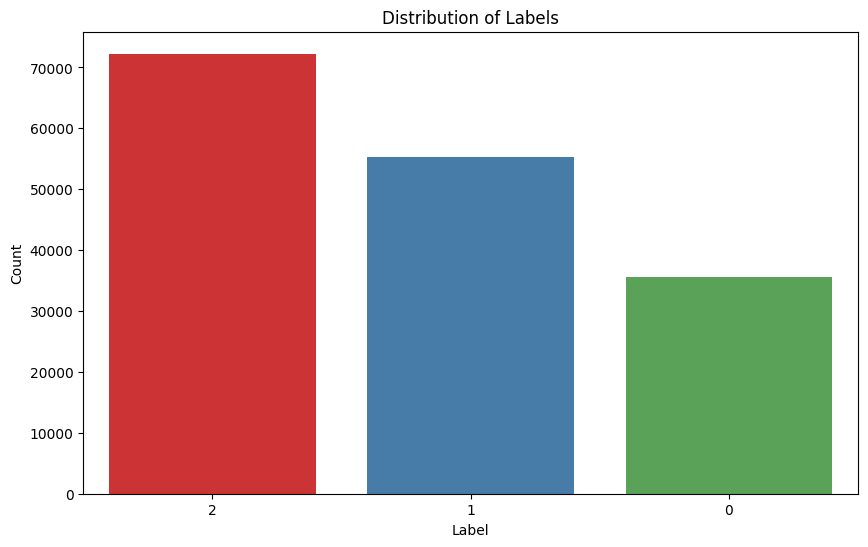

In [26]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label',data=tweet,order=tweet['label'].value_counts().index,palette='Set1')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [23]:
y=keras.utils.to_categorical(tweet['label'],num_classes=3)
y.shape

(162969, 3)

In [27]:
index_to_label={0:'negative',1:'neutral',2:'positive'}

#Tokenize & pad

In [32]:
x_test=tweet['clean_text'].values


vocab_size = 20000   #max number of words in vocab
max_len    = 50    #max length of each sentence (tokens)

tokenizer=Tokenizer(num_words=vocab_size,oov_token='<oov>')
tokenizer.fit_on_texts(x_test)

sequences=tokenizer.texts_to_sequences(x_test)
X=pad_sequences(sequences,maxlen=max_len,padding='post',truncating='post')

print('x shape',X.shape)
print('y shape',y.shape)


x shape (162969, 50)
y shape (162969, 3)


#lstm

In [34]:
embedding_dim=128
lstm_units=128

model=keras.Sequential([
    layers.Input(shape=(max_len,)),
    layers.Embedding(input_dim=vocab_size,output_dim=embedding_dim,
                     input_length=max_len),
    layers.SpatialDropout1D(0.2),

    layers.LSTM(lstm_units,dropout=0.2,recurrent_dropout=0.2),

    layers.Dense(3,activation='softmax')
])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 128)        │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 50, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,691,971 (10.27 MB)

 Trainable params: 2,691,971 (10.27 MB)

 Non-trainable params: 0 (0.00 B)

#Compile

In [35]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#train

In [36]:
history=model.fit(X,y,batch_size=64,epochs=8,validation_split=0.2,verbose=1)

Epoch 1/8
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 464s 225ms/step - accuracy: 0.7029 - loss: 0.6741 - val_accuracy: 0.9343 - val_loss: 0.2004
Epoch 2/8
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 427s 210ms/step - accuracy: 0.9448 - loss: 0.1734 - val_accuracy: 0.9615 - val_loss: 0.1280
Epoch 3/8
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 434s 206ms/step - accuracy: 0.9703 - loss: 0.0974 - val_accuracy: 0.9678 - val_loss: 0.1111
Epoch 4/8
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 429s 210ms/step - accuracy: 0.9770 - loss: 0.0758 - val_accuracy: 0.9687 - val_loss: 0.1080
Epoch 5/8
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 427s 209ms/step - accuracy: 0.9824 - loss: 0.0575 - val_accuracy: 0.9677 - val_loss: 0.1192
Epoch 6/8
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 446s 211ms/step - accuracy: 0.9861 - loss: 0.0470 - val_accuracy: 0.9678 - val_loss: 0.1216
Epoch 7/8
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 438s 210ms/step - accuracy: 0.9890 - loss: 0.0369 - val_accuracy: 0.9639 - val_loss: 0.1341
Epoch 8/8
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 419s 206ms/step - accuracy: 

#Plot accuracy and loss

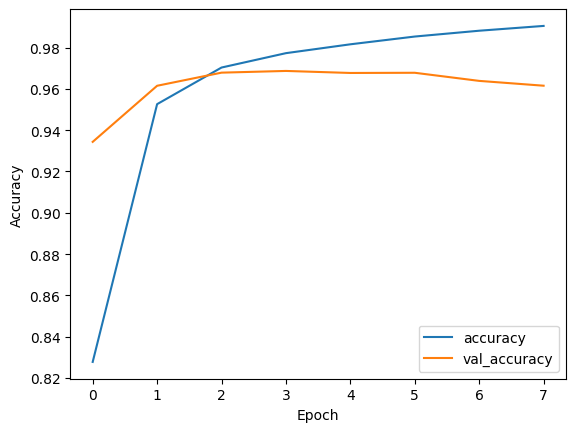

In [37]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

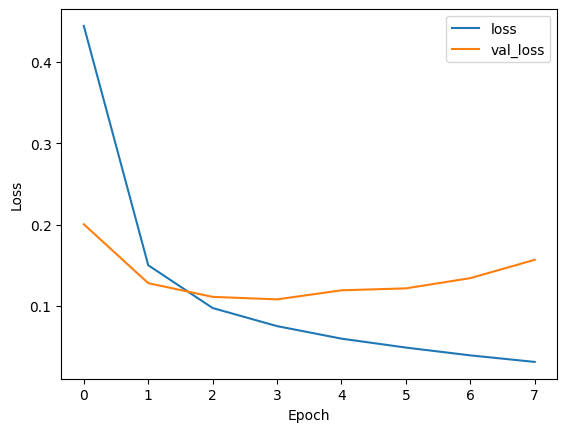

In [38]:
#loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

#evaluate

In [39]:
test_loss,test_acc=model.evaluate(X,y)
print('Test Accuracy:',test_acc)
print('loss',test_loss)

5093/5093 ━━━━━━━━━━━━━━━━━━━━ 176s 34ms/step - accuracy: 0.9951 - loss: 0.0184
Test Accuracy: 0.9891267418861389
loss 0.04319309815764427


#predict_new text

In [40]:
def predict_text(text):
  clean=clean_text(text)
  seq=tokenizer.texts_to_sequences([clean])
  pad= pad_sequences(seq,maxlen=max_len,padding='post',truncating='post')
  pred=model.predict(pad)
  cls=np.argmax(pred)



  print("Text        :", text)
  print("Cleaned     :", clean)
  print("Predicted id:", cls, "→", index_to_label[cls])
  print("Probabilities:", pred)


predict_text("I really love this, it is amazing!")
predict_text("This is terrible and I hate it.")
predict_text("Not sure what to think about this.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Text        : I really love this, it is amazing!
Cleaned     : i really love amazing
Predicted id: 2 → positive
Probabilities: [[7.9903448e-06 4.4035172e-05 9.9994802e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Text        : This is terrible and I hate it.
Cleaned     : terrible i hate
Predicted id: 0 → negative
Probabilities: [[9.9978966e-01 1.8900921e-04 2.1280212e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Text        : Not sure what to think about this.
Cleaned     : not sure what think about
Predicted id: 0 → negative
Probabilities: [[0.9627369  0.01905647 0.01820656]]
